In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import os
from tqdm import tqdm
from sklearn.neighbors import KDTree
from numba import jit
from scipy.stats import gaussian_kde

In [139]:
def redshift_kde_weights(z):
    kde = gaussian_kde(z)
    w = 1/kde.evaluate(z)
    return w, kde

def redshift_weigth(z, bins=100):
    _bins = pd.cut(z, bins=np.linspace(z.min(), z.max() + 1, bins))
    w = z.map(1/z.groupby(_bins).sum()) 
    return w.to_numpy()


In [140]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [141]:
def cone_synthetic_catalogue(kde, theta, phi, N):
    """
    Generate a synthetic catalogue with N object from a uniform density field
    """
    r_rand = kde.resample(N)[0]
#     r_rand = np.random.uniform(r.min(), r.max(), N)
    theta_rand = np.random.uniform(theta.min(), theta.max(), N)
    phi_rand = np.random.uniform(phi.min(), phi.max(), N)
    return r_rand, theta_rand, phi_rand

In [142]:
def center_selection(r, theta, phi, fraction):
    theta_center = (theta.max() + theta.min())/2
    phi_center = (phi.max() + phi.min())/2
    out = theta < (theta.max() + theta_center) * fraction
    out *= theta > (theta_center + theta.min()) * fraction
    out *= phi < (phi.max() + phi_center) * fraction
    out *= phi > (phi_center + phi.min()) * fraction
    return out


In [143]:
@jit
def brute_force(positions, weights):
    N = positions.shape[0]
    size = N * (N - 1) //2
    pair_distance = np.zeros(size)
    w = np.zeros_like(pair_distance)
    k = 0
    for i in range(N):
        for j in range(i + 1, N):
            d = positions[i] - positions[j]
            pair_distance[k] = np.sqrt(np.dot(d, d))
            w[k] = weights[i]
            k += 1
    w /= w.sum()
    return pair_distance, w

In [170]:
h = 0.72
Omega_m = 0.3
data_path = "../../data/Skyserver_SQL1_20_2021 12 59 33 AM.csv"
fraction = 0.3
cone_selection = 0.4
bins = np.linspace(20, 300, 200)

cosmo = FlatLambdaCDM(70 * h, Omega_m)
data = pd.read_csv(data_path, skiprows=1)
# preprocessing 
data = data[(data["Spec_redshift"] > 1e-4) & (data["Spec_redshift"] < 1)]

M = int(fraction * len(data)) # sample size
if fraction < 1:
    indexes = np.random.choice(range(len(data)), size=M, replace=False)
    data = data.iloc[indexes, :]

# weights = redshift_weigth(data["Spec_redshift"])
r = cosmo.comoving_distance(data["Spec_redshift"].to_numpy()).value # remove unit to accelerate compute speed
theta = np.deg2rad(data["dec"]).to_numpy()
phi = np.deg2rad(data["ra"]).to_numpy()

In [171]:
kde = gaussian_kde(r)
weights = 1/kde.evaluate(r)
x, y, z = spherical_to_cartesian(r, theta, phi)
positions = np.column_stack([x, y, z])

N = r.size
N_r = r.size# number of galaxies in the catalogue
r_rand, theta_rand, phi_rand = cone_synthetic_catalogue(kde, theta, phi, N_r)
positions_rand = np.column_stack(spherical_to_cartesian(r_rand, theta_rand, phi_rand))
weights_rand = 1/kde.evaluate(r_rand)

In [188]:
print("using brute_force method")
pair_distance, w = brute_force(positions, weights)
pair_distance_rand, wr = brute_force(positions_rand, weights_rand)
count, distance = np.histogram(pair_distance, bins=bins, weights=w, density=True)
count_rand, distance_rand = np.histogram(pair_distance_rand, 
                                         bins=bins, weights=None, density=True)

# transform count into cumulative sum
cum_count = np.cumsum(count)
cum_count_rand = np.cumsum(count_rand)
# get bin centers
distance = (distance[1:] + distance[:-1])/2
N_cal = cum_count / cum_count_rand


using brute_force method


Text(0, 0.5, '$\\xi(r)$')

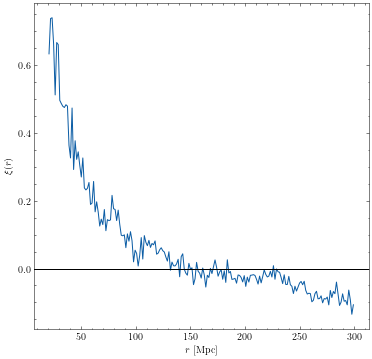

In [189]:
plt.style.use("science")
plt.figure(figsize=(6, 6))
xi = count / count_rand - 1
plt.plot(distance, xi)
plt.axhline(0, color="k")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi(r)$")
# plt.xscale("log")

In [126]:
print("using kdtree method")
kd = KDTree(positions, leaf_size=40)
kd_r = KDTree(positions_rand, leaf_size=40)

# take as center only a portion of the cone

distances = np.linspace(10, 200, 200)
N_cat = np.zeros_like(distances)
N_rand = np.zeros_like(distances)
for i, d in enumerate(tqdm(distances)):
    N_cat[i] = (kd.query_radius(positions, d, count_only=True) * weights).sum()/weights.sum()
    N_rand[i] = kd_r.query_radius(positions_rand, d, count_only=True).mean()
    
N_cal = N_cat / N_rand

  4%|▍         | 8/200 [00:00<00:02, 77.16it/s]

using kdtree method


100%|██████████| 200/200 [00:05<00:00, 37.80it/s]


Text(0, 0.5, '$\\xi(r)$')

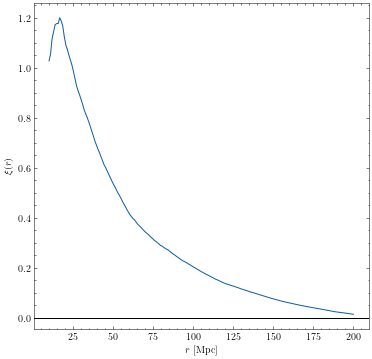

In [117]:
plt.style.use("science")
plt.figure(figsize=(6, 6))
xi = N_cal- 1
plt.plot(distances, xi)
plt.axhline(0, color="k")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi(r)$")
# plt.xscale("log")